
# Esports earnings distribution — Battle Royale (Histogram + KDE)

This notebook reproduces the **Earnings distribution in this genre** visualization using Python, pandas, and matplotlib.

1. Loads `esports_games.csv`
2. Filters games where `Genre == "Battle Royale"`
3. Plots a histogram of **total earnings per game** on a log scale
4. Overlays a smoothed KDE curve computed on the same log values


In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Make plots a bit sharper
%config InlineBackend.figure_format = "retina"


In [2]:

# Path assumes this notebook lives next to the CSV files.
games_path = "esports_games.csv"

games_df = pd.read_csv(games_path)

# Filter for a single genre (Battle Royale)
genre = "Battle Royale"
br_games = games_df[games_df["Genre"] == genre].copy()

# Keep only strictly positive earnings, then take log10
earnings = br_games["TotalEarnings"].astype(float)
earnings = earnings[earnings > 0]

log_earnings = np.log10(earnings.values)

print(f"Total games in dataset: {len(games_df):,}")
print(f"Games in genre '{genre}': {len(br_games):,}")
print(f"Games with positive earnings: {len(log_earnings):,}")


Total games in dataset: 669
Games in genre 'Battle Royale': 17
Games with positive earnings: 13


In [3]:

def epanechnikov_kernel(u: np.ndarray) -> np.ndarray:
    """Epanechnikov kernel used in the React/D3 version."""
    mask = np.abs(u) <= 1
    out = np.zeros_like(u, dtype=float)
    out[mask] = 0.75 * (1.0 - u[mask] ** 2)
    return out

def kde_epanechnikov(values, x_grid, bandwidth):
    """Simple 1D KDE with Epanechnikov kernel.

    values   : 1D array of sample points (log10 earnings)
    x_grid   : 1D grid where we evaluate the density
    bandwidth: smoothing parameter (on log10 scale)
    """
    values = np.asarray(values)
    x_grid = np.asarray(x_grid)

    densities = np.zeros_like(x_grid, dtype=float)
    n = len(values)

    for i, x in enumerate(x_grid):
        u = (x - values) / bandwidth
        densities[i] = epanechnikov_kernel(u).sum()

    # Normalize to integrate to 1 (roughly)
    densities /= (n * bandwidth)
    return densities


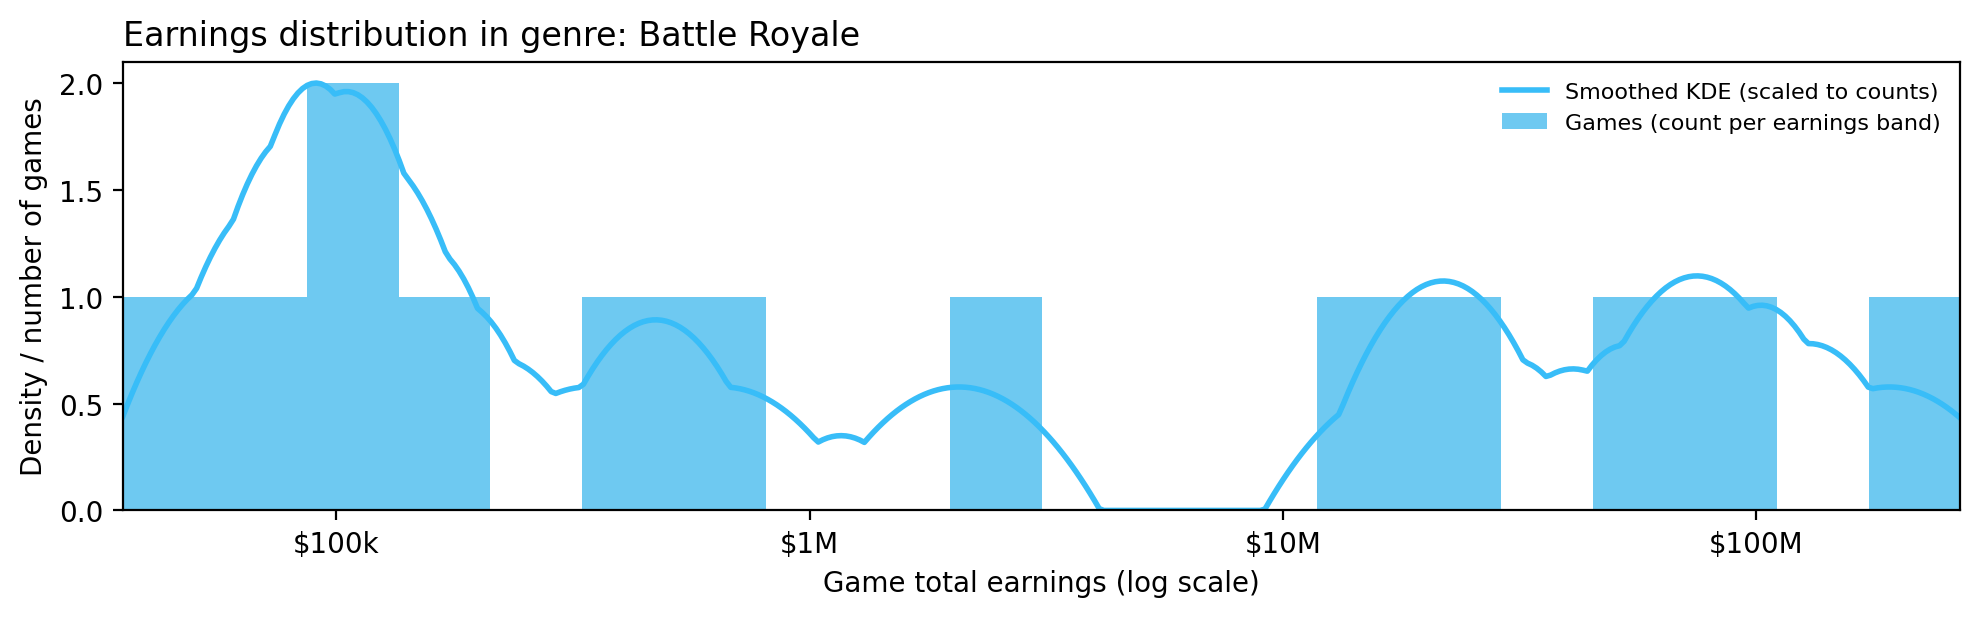

In [4]:

if len(log_earnings) == 0:
    raise ValueError("No positive earnings found for this genre.")

# --- Histogram setup (on log10 values) ---
min_log = log_earnings.min()
max_log = log_earnings.max()

pad = 0.15  # small padding so bars don't touch edges
domain_min = min_log - pad
domain_max = max_log + pad

# Choose number of bins similar to the React chart
n_bins = 20
bins = np.linspace(domain_min, domain_max, n_bins + 1)
counts, edges = np.histogram(log_earnings, bins=bins)

# Bin centers (not strictly needed, but sometimes useful)
centers = 0.5 * (edges[:-1] + edges[1:])

max_count = counts.max()

# --- KDE on the same log10 domain ---
# Bandwidth similar to the D3 version: range / 12
bandwidth = (max_log - min_log) / 12 if max_log > min_log else 0.2

x_grid = np.linspace(domain_min, domain_max, 400)
density = kde_epanechnikov(log_earnings, x_grid, bandwidth)

# Rescale KDE to roughly match the histogram height (so they share the y-axis)
density_scaled = density * (max_count / density.max())

# --- Plot ---
fig, ax = plt.subplots(figsize=(10, 3.2))

# Histogram bars
ax.bar(
    centers,
    counts,
    width=np.diff(edges),
    align="center",
    color="#0ea5e9",
    alpha=0.6,
    edgecolor="none",
    label="Games (count per earnings band)",
)

# KDE curve
ax.plot(
    x_grid,
    density_scaled,
    color="#38bdf8",
    linewidth=2,
    label="Smoothed KDE (scaled to counts)",
)

# X-axis ticks at nice money values: 10^4 .. 10^10
log_ticks = np.arange(4, 11)  # 10k to 10B
# Keep ticks inside domain
log_ticks = log_ticks[(log_ticks >= domain_min) & (log_ticks <= domain_max)]

ax.set_xticks(log_ticks)
ax.set_xlim(domain_min, domain_max)

# Format tick labels as money (10k, 100k, 1M, 10M, ...)
def money_label(exp):
    value = 10 ** exp
    # Use a compact formatter similar to D3 "~s"
    if value >= 1e9:
        return f"${value/1e9:.0f}B"
    elif value >= 1e6:
        return f"${value/1e6:.0f}M"
    elif value >= 1e3:
        return f"${value/1e3:.0f}k"
    else:
        return f"${value:.0f}"

ax.set_xticklabels([money_label(t) for t in log_ticks])

# Y-axis label
ax.set_ylabel("Density / number of games", fontsize=10)

# X-axis label
ax.set_xlabel("Game total earnings (log scale)", fontsize=10)

ax.set_title(
    f"Earnings distribution in genre: {genre}",
    fontsize=12,
    loc="left",
)

ax.grid(False)
ax.legend(loc="upper right", fontsize=8, frameon=False)

plt.tight_layout()
plt.show()
